In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from meteostat import Point, Daily
import scipy.stats as stats

from IPython.display import display
pd.set_option('display.max_columns', None)


# 1-Data Okuma & Düzenleme

In [2]:
med = pd.read_csv("med.csv")
train = pd.read_csv("train.csv")
sample = pd.read_csv("sample_submission.csv")
t_calendar = pd.read_csv("Turkish_Calendar.csv")
Elektrik_Fiyat = pd.read_excel("Elektrik_Fiyatları.xlsx")
Turist_Say = pd.read_excel("Turist_Sayısı.xlsx")
Tesis_Sayisi = pd.read_excel("Tesisi_Sayisi.xlsx")

In [3]:
train["Tarih"] = pd.to_datetime(train["Tarih"])
med["Tarih"] = pd.to_datetime(med["Tarih"])
sample["Tarih"] = pd.to_datetime(sample["Tarih"])

## 1.1.Data tarih detay ekleme.

In [4]:
t_calendar.head()

,CALENDAR_SK,CALENDAR_DATE,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,MONTH_SK,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,SPECIAL_DAY_SK,SPECIAL_DAY_SK2
0,20241231,2024-12-31,31,2,4,4,202412,N,53,N,100,200,N,NaN,NaN
1,20241230,2024-12-30,30,1,4,4,202412,N,53,N,100,200,N,NaN,NaN
2,20241229,2024-12-29,29,7,4,4,202412,Y,53,N,100,200,Y,NaN,NaN
3,20241228,2024-12-28,28,6,4,4,202412,Y,52,N,100,200,Y,NaN,NaN
4,20241227,2024-12-27,27,5,4,4,202412,N,52,N,100,200,N,NaN,NaN


In [5]:
all_data = pd.concat([train, sample])
all_data["CALENDAR_DATE"] = all_data.Tarih.astype("string").str.slice(stop=10)
t_calendar["CALENDAR_DATE"] = t_calendar["CALENDAR_DATE"] .str.slice(stop=10)
Elektrik_Fiyat["CALENDAR_DATE"] = Elektrik_Fiyat["CALENDAR_DATE"].astype("string").str.slice(stop=10)
med["CALENDAR_DATE"] = med["Tarih"].astype("string").str.slice(stop=10)

med.drop(columns="Tarih", inplace=True)
med["IS_MED"] = 1

In [6]:
all_data = all_data.merge(t_calendar, how="left", on="CALENDAR_DATE")
all_data = all_data.merge(med, how="left", on="CALENDAR_DATE")
all_data = all_data.merge(Elektrik_Fiyat, how="left", on="CALENDAR_DATE")

all_data["IS_MED"].fillna(0, inplace=True)

all_data["TARIH_COL_1"] = all_data["Tarih"]
all_data = all_data.set_index("Tarih")



In [7]:
all_data["RAMADAN_FLAG"].replace(["Y","N"],[1,0], inplace=True)
all_data["WEEKEND_FLAG"].replace(["Y","N"],[1,0], inplace=True)
all_data["PUBLIC_HOLIDAY_FLAG"].replace(["Y","N"],[1,0], inplace=True)
all_data["HOUR"] =  all_data.index.hour
all_data["MONTH"] =  all_data.index.month
all_data["YEAR"] =  all_data.index.year

all_data = all_data.merge(Tesis_Sayisi, how="left", on="YEAR")
all_data = all_data.merge(Turist_Say, how="left", on=["YEAR", "MONTH"])

all_data["TARIH_COL"] = all_data["TARIH_COL_1"]
all_data = all_data.set_index("TARIH_COL_1")

all_data["AMOUNT"] = all_data["Dağıtılan Enerji (MWh)"]

all_data.drop(columns=["Dağıtılan Enerji (MWh)","CALENDAR_DATE", "CALENDAR_SK", "MONTH_SK","SPECIAL_DAY_SK", "SPECIAL_DAY_SK2"], inplace=True)

for col in ['DAY_OF_MONTH', 'DAY_OF_WEEK_SK', 'SEASON_SK', 'QUARTER_OF_YEAR',
       'WEEKEND_FLAG', 'WEEK_OF_YEAR', 'RAMADAN_FLAG', 'RELIGIOUS_DAY_FLAG_SK',
       'NATIONAL_DAY_FLAG_SK', 'PUBLIC_HOLIDAY_FLAG', 'MONTH', 'YEAR']:
    all_data[col] = all_data[col].astype("category")

In [8]:
all_data.head()

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,TESIS_SAYISI,KISI_SAYISI,TARIH_COL,AMOUNT
TARIH_COL_1,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,0,1,2018,207,24330,2018-01-01 00:00:00,1593.944216
2018-01-01 01:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,1,1,2018,207,24330,2018-01-01 01:00:00,1513.933887
2018-01-01 02:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,2,1,2018,207,24330,2018-01-01 02:00:00,1402.612637
2018-01-01 03:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,3,1,2018,207,24330,2018-01-01 03:00:00,1278.527266
2018-01-01 04:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,4,1,2018,207,24330,2018-01-01 04:00:00,1220.697701


## 1.2.Hava Durumu Verileri

**Column	Description	Type**
station	The Meteostat ID of the weather station (only if query refers to multiple stations)	String

time::The date	Datetime64

tavg::The average air temperature in °C	Float64

tmin::The minimum air temperature in °C	Float64

tmax::The maximum air temperature in °C	Float64

prcp::The daily precipitation total in mm	Float64

snow::The snow depth in mm	Float64

wdir::The average wind direction in degrees (°)	Float64

wspd::The average wind speed in km/h	Float64

wpgt::The peak wind gust in km/h	Float64

pres::The average sea-level air pressure in hPa	Float64

tsun::The daily sunshine total in minutes (m)	Float64

In [9]:
from meteostat import Hourly

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2022, 12, 31, 23, 59)

# Get hourly data
Izmir_Place = Point(38.423733, 27.142826) 
data_Izmir = Hourly('17219', start, end)
data_Izmir = data_Izmir.fetch()

#https://www.windy.com/station/wmo-17186?38.611,27.436,12
#2021 itibarı ile ulaştığımız için ve %15 etkisden dolayı çıkarıldı.
# Get hourly data
# Manisa_Place = Point(38.630554, 27.422222)
data_Manisa = Hourly('17218', start, end)
data_Manisa = data_Manisa.fetch()

# Print DataFrame
meteo_data_Izmir = pd.DataFrame(data_Izmir)
meteo_data_Manisa = pd.DataFrame(data_Manisa)

meteo_data_Izmir.drop(columns=["prcp", "snow", "wpgt", "tsun","coco"], inplace=True)
meteo_data_Manisa.drop(columns=["prcp", "snow", "wpgt", "tsun","coco"], inplace=True)

meteo_data_Manisa.head(15)

,temp,dwpt,rhum,wdir,wspd,pres
time,,,,,,
2018-01-01 00:00:00,2.0,0.8,92.0,360.0,0.0,1020.6
2018-01-01 01:00:00,2.0,1.0,93.0,NaN,0.0,NaN
2018-01-01 02:00:00,1.0,0.0,93.0,NaN,0.0,NaN
2018-01-01 03:00:00,0.6,-0.4,93.0,360.0,0.0,1019.9
2018-01-01 04:00:00,0.0,-1.0,93.0,320.0,5.4,NaN
2018-01-01 05:00:00,0.0,-1.0,93.0,340.0,3.6,NaN
2018-01-01 06:00:00,1.0,0.3,95.0,360.0,0.0,1020.3
2018-01-01 07:00:00,6.0,3.0,81.0,120.0,7.6,NaN
2018-01-01 08:00:00,8.0,2.0,66.0,110.0,13.0,NaN


In [10]:
all_data = all_data.merge(meteo_data_Izmir, how="left", left_index=True, right_index=True )
all_data = all_data.merge(meteo_data_Manisa, how="left", left_index=True, right_index=True, suffixes=('_IZMIR','_MANISA'))

all_data.head()

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,TESIS_SAYISI,KISI_SAYISI,TARIH_COL,AMOUNT,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA
TARIH_COL_1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,0,1,2018,207,24330,2018-01-01 00:00:00,1593.944216,5.2,1.9,79.0,30.0,16.6,1020.0,2.0,0.8,92.0,360.0,0.0,1020.6
2018-01-01 01:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,1,1,2018,207,24330,2018-01-01 01:00:00,1513.933887,7.0,1.1,66.0,40.0,16.6,1019.0,2.0,1.0,93.0,NaN,0.0,NaN
2018-01-01 02:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,2,1,2018,207,24330,2018-01-01 02:00:00,1402.612637,4.0,1.0,81.0,360.0,11.2,1019.0,1.0,0.0,93.0,NaN,0.0,NaN
2018-01-01 03:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,3,1,2018,207,24330,2018-01-01 03:00:00,1278.527266,3.5,0.9,83.0,10.0,13.0,1020.0,0.6,-0.4,93.0,360.0,0.0,1019.9
2018-01-01 04:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,4,1,2018,207,24330,2018-01-01 04:00:00,1220.697701,2.0,1.0,93.0,250.0,3.6,1019.0,0.0,-1.0,93.0,320.0,5.4,NaN


In [11]:
izmir_nufus = pd.read_html('https://www.nufusu.com/il/izmir-nufusu')[1]
izmir_nufus_yogunlugu = pd.read_html('https://www.nufusu.com/il/izmir-nufusu')[2]
izmir_nufus_yogunlugu.drop(columns=["İzmir Nüfusu"], inplace=True)
izmir_merge = izmir_nufus.merge(izmir_nufus_yogunlugu, how="left", on="Yıl")
izmir_merge.rename(columns={"Yıl": "YEAR", "Nüfus Yoğunluğu": "İzmir Nüfus Yoğunluğu", "Artış Hızı": "İzmir Nüfus Artış Hızı"}, inplace=True)

manisa_nufus = pd.read_html('https://www.nufusu.com/il/manisa-nufusu')[1]
manisa_nufus_yogunlugu = pd.read_html('https://www.nufusu.com/il/manisa-nufusu')[2]
manisa_nufus_yogunlugu.drop(columns=["Manisa Nüfusu"], inplace=True)
manisa_merge = manisa_nufus.merge(manisa_nufus_yogunlugu, how="left", on="Yıl")
manisa_merge.rename(columns={"Yıl": "YEAR", "Nüfus Yoğunluğu": "Manisa Nüfus Yoğunluğu", "Artış Hızı": "Manisa Nüfus Artış Hızı"}, inplace=True)

display(izmir_merge.head(10))
display(manisa_merge.head(10))

,YEAR,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu
0,2014,4.113.072,% 1.28,343 /km2
1,2015,4.168.415,% 1.35,347 /km2
2,2016,4.223.545,% 1.32,352 /km2
3,2017,4.279.677,% 1.33,356 /km2
4,2018,4.320.519,% 0.95,360 /km2
5,2019,4.367.251,% 1.08,364 /km2
6,2020,4.394.694,% 0.63,366 /km2
7,2021,4.425.789,% 0.71,369 /km2
8,2022,4.462.056,% 0.82,372 /km2


,YEAR,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu
0,2014,1.367.905,% 0.62,103 /km2
1,2015,1.380.366,% 0.91,104 /km2
2,2016,1.396.945,% 1.20,105 /km2
3,2017,1.413.041,% 1.15,106 /km2
4,2018,1.429.643,% 1.17,108 /km2
5,2019,1.440.611,% 0.77,109 /km2
6,2020,1.450.616,% 0.69,109 /km2
7,2021,1.456.626,% 0.41,110 /km2
8,2022,1.468.279,% 0.80,111 /km2


In [12]:
izmir_merge["İzmir Nüfusu"] = (izmir_merge["İzmir Nüfusu"].apply(lambda element: element.replace(".", ""))).astype(float)
izmir_merge["İzmir Nüfus Artış Hızı"] = (izmir_merge["İzmir Nüfus Artış Hızı"].apply(lambda element: element.replace("% ", ""))).astype(float)
izmir_merge["İzmir Nüfus Yoğunluğu"] = izmir_merge["İzmir Nüfus Yoğunluğu"].apply(lambda element: element.replace(" /km2", "")).astype(float)

manisa_merge["Manisa Nüfusu"] = (manisa_merge["Manisa Nüfusu"].apply(lambda element: element.replace(".", ""))).astype(float)
manisa_merge["Manisa Nüfus Artış Hızı"] = (manisa_merge["Manisa Nüfus Artış Hızı"].apply(lambda element: element.replace("% ", ""))).astype(float)
manisa_merge["Manisa Nüfus Yoğunluğu"] = manisa_merge["Manisa Nüfus Yoğunluğu"].apply(lambda element: element.replace(" /km2", "")).astype(float)

all_data = all_data.merge(izmir_merge, how="left", on="YEAR")
all_data = all_data.merge(manisa_merge, how="left", on="YEAR")
all_data.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,TESIS_SAYISI,KISI_SAYISI,TARIH_COL,AMOUNT,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu
0,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,0,1,2018,207,24330,2018-01-01 00:00:00,1593.944216,5.2,1.9,79.0,30.0,16.6,1020.0,2.0,0.8,92.0,360.0,0.0,1020.6,4320519.0,0.95,360.0,1429643.0,1.17,108.0
1,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,1,1,2018,207,24330,2018-01-01 01:00:00,1513.933887,7.0,1.1,66.0,40.0,16.6,1019.0,2.0,1.0,93.0,NaN,0.0,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0
2,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,2,1,2018,207,24330,2018-01-01 02:00:00,1402.612637,4.0,1.0,81.0,360.0,11.2,1019.0,1.0,0.0,93.0,NaN,0.0,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0
3,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,3,1,2018,207,24330,2018-01-01 03:00:00,1278.527266,3.5,0.9,83.0,10.0,13.0,1020.0,0.6,-0.4,93.0,360.0,0.0,1019.9,4320519.0,0.95,360.0,1429643.0,1.17,108.0
4,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,4,1,2018,207,24330,2018-01-01 04:00:00,1220.697701,2.0,1.0,93.0,250.0,3.6,1019.0,0.0,-1.0,93.0,320.0,5.4,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0


In [13]:
all_data

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,TESIS_SAYISI,KISI_SAYISI,TARIH_COL,AMOUNT,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu
0,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.230900,0.130400,0.133600,0,1,2018,207,24330,2018-01-01 00:00:00,1593.944216,5.2,1.9,79.0,30.0,16.6,1020.0,2.0,0.8,92.0,360.0,0.0,1020.6,4320519.0,0.95,360.0,1429643.0,1.17,108.0
1,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.230900,0.130400,0.133600,1,1,2018,207,24330,2018-01-01 01:00:00,1513.933887,7.0,1.1,66.0,40.0,16.6,1019.0,2.0,1.0,93.0,NaN,0.0,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0
2,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.230900,0.130400,0.133600,2,1,2018,207,24330,2018-01-01 02:00:00,1402.612637,4.0,1.0,81.0,360.0,11.2,1019.0,1.0,0.0,93.0,NaN,0.0,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0
3,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.230900,0.130400,0.133600,3,1,2018,207,24330,2018-01-01 03:00:00,1278.527266,3.5,0.9,83.0,10.0,13.0,1020.0,0.6,-0.4,93.0,360.0,0.0,1019.9,4320519.0,0.95,360.0,1429643.0,1.17,108.0
4,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.230900,0.130400,0.133600,4,1,2018,207,24330,2018-01-01 04:00:00,1220.697701,2.0,1.0,93.0,250.0,3.6,1019.0,0.0,-1.0,93.0,320.0,5.4,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40891,31,3,3,3,0,36,0,100,200,0,0.0,2.1700,3.420,1.5972,2.437383,0.335187,0.342716,19,8,2022,266,251303,2022-08-31 19:00:00,0.000000,27.0,20.1,66.0,330.0,18.4,1009.0,25.0,20.0,74.0,320.0,11.2,1010.0,4462056.0,0.82,372.0,1468279.0,0.80,111.0
40892,31,3,3,3,0,36,0,100,200,0,0.0,2.1700,3.420,1.5972,2.437383,0.335187,0.342716,20,8,2022,266,251303,2022-08-31 20:00:00,0.000000,25.0,20.0,74.0,10.0,11.2,1009.0,24.0,19.9,78.0,330.0,13.0,1009.0,4462056.0,0.82,372.0,1468279.0,0.80,111.0
40893,31,3,3,3,0,36,0,100,200,0,0.0,2.1700,3.420,1.5972,2.437383,0.335187,0.342716,21,8,2022,266,251303,2022-08-31 21:00:00,0.000000,24.6,20.5,78.0,10.0,5.4,1009.5,24.1,19.8,77.0,0.0,0.0,1009.8,4462056.0,0.82,372.0,1468279.0,0.80,111.0
40894,31,3,3,3,0,36,0,100,200,0,0.0,2.1700,3.420,1.5972,2.437383,0.335187,0.342716,22,8,2022,266,251303,2022-08-31 22:00:00,0.000000,23.0,21.1,89.0,130.0,7.6,1009.0,23.0,20.0,83.0,360.0,3.6,1009.0,4462056.0,0.82,372.0,1468279.0,0.80,111.0


## 1.3.Kategorik tipli değişkenlerin düzenlenmesi

In [14]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40896 entries, 0 to 40895
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   DAY_OF_MONTH                           40896 non-null  category      
 1   DAY_OF_WEEK_SK                         40896 non-null  category      
 2   SEASON_SK                              40896 non-null  category      
 3   QUARTER_OF_YEAR                        40896 non-null  category      
 4   WEEKEND_FLAG                           40896 non-null  category      
 5   WEEK_OF_YEAR                           40896 non-null  category      
 6   RAMADAN_FLAG                           40896 non-null  category      
 7   RELIGIOUS_DAY_FLAG_SK                  40896 non-null  category      
 8   NATIONAL_DAY_FLAG_SK                   40896 non-null  category      
 9   PUBLIC_HOLIDAY_FLAG                    40896 non-null  catego

In [15]:
kategorik_col =  ['DAY_OF_MONTH', 'DAY_OF_WEEK_SK', 'SEASON_SK', 'QUARTER_OF_YEAR','WEEKEND_FLAG', 'WEEK_OF_YEAR', 'RAMADAN_FLAG', 'RELIGIOUS_DAY_FLAG_SK',
       'NATIONAL_DAY_FLAG_SK', 'PUBLIC_HOLIDAY_FLAG', 'IS_MED', 'HOUR',
       'MONTH']
for col in kategorik_col:
  all_data[col] = all_data[col].astype(int)


## 1.4.Boş değerlerin KNN ile doldurulması

In [16]:
all_data.describe()

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,KISI_SAYISI,TARIH_COL,AMOUNT,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu
count,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896,40896.000000,40894.000000,40894.000000,40894.000000,40554.000000,40893.000000,40808.000000,40289.000000,40287.000000,40287.000000,36244.000000,40289.000000,28602.000000,4.089600e+04,40896.000000,40896.000000,4.089600e+04,40896.000000,40896.000000
mean,15.725939,3.996479,2.419601,2.419601,0.285211,25.803404,0.087441,101.170775,200.026995,0.311620,0.017606,0.865291,1.164519,0.505362,0.717968,0.216032,0.221175,11.500000,6.238263,2019.856808,76780.519953,2020-05-01 23:30:00,1803.389228,17.806595,9.378733,62.406441,209.646077,16.591869,1013.508297,18.225779,9.991978,62.075608,192.594802,12.415513,1014.134651,4.389194e+06,0.839167,365.784624,1.447787e+06,0.765663,109.285211
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.448200,0.452000,0.230900,0.230900,0.126500,0.129000,0.000000,1.000000,2018.000000,30.000000,2018-01-01 00:00:00,0.000000,-6.000000,-14.000000,2.000000,0.000000,0.000000,993.000000,-5.000000,-15.000000,12.000000,0.000000,0.000000,991.000000,4.320519e+06,0.630000,360.000000,1.429643e+06,0.410000,108.000000
25%,8.000000,2.000000,1.000000,1.000000,0.000000,13.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.547900,0.714800,0.302700,0.415000,0.154000,0.157600,5.750000,3.000000,2019.000000,24175.000000,2019-03-02 23:45:00,1476.704767,11.000000,5.900000,45.000000,110.000000,5.400000,1009.000000,12.000000,6.100000,48.000000,80.000000,5.400000,1010.000000,4.367251e+06,0.710000,364.000000,1.440611e+06,0.690000,109.000000
50%,16.000000,4.000000,2.000000,2.000000,0.000000,25.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.710200,0.945000,0.362700,0.542100,0.212400,0.217200,11.500000,6.000000,2020.000000,41652.000000,2020-05-01 23:30:00,1803.483433,17.000000,10.100000,61.000000,200.000000,16.600000,1013.000000,18.000000,10.800000,63.000000,200.000000,11.200000,1013.500000,4.394694e+06,0.820000,366.000000,1.450616e+06,0.770000,109.000000
75%,23.000000,6.000000,3.000000,3.000000,1.000000,38.000000,0.000000,100.000000,200.000000,1.000000,0.000000,0.916000,1.217000,0.474300,0.706300,0.265100,0.271100,17.250000,9.000000,2021.000000,126748.000000,2021-07-01 23:15:00,2122.347112,25.000000,13.900000,81.000000,350.000000,25.900000,1017.000000,25.000000,14.800000,77.000000,320.000000,18.400000,1018.000000,4.425789e+06,0.950000,369.000000,1.456626e+06,0.800000,110.000000
max,31.000000,7.000000,4.000000,4.000000,1.000000,53.000000,1.000000,163.000000,204.000000,1.000000,1.000000,2.170000,3.420000,1.597200,2.437383,0.335187,0.342716,23.000000,12.000000,2022.000000,281537.000000,2022-08-31 23:00:00,3633.105297,41.000000,22.800000,100.000000,360.000000,63.000000,1037.200000,40.000000,23.100000,100.000000,360.000000,59.400000,1038.000000,4.462056e+06,1.080000,372.000000,1.468279e+06,1.170000,111.000000
std,8.798882,2.000315,1.097649,1.097649,0.451521,14.743109,0.282484,8.120355,0.279127,0.463161,0.131515,0.498314,0.788351,0.403566,0.585737,0.065260,0.066784,6.922271,3.381785,1.354686,74819.376019,NaN,488.357796,8.963949,5.936970,21.446071,135.000143,11.283268,5.799821,8.5

In [17]:
all_data_knn = all_data.drop(columns=["AMOUNT"])

all_data_train = all_data_knn[:40152]
all_data_sample = all_data_knn[40152:]

In [18]:
from sklearn.impute import KNNImputer

# TRAIN
# Finding the columns that have any NaN value
num_cols_include_nan_train = [col for col in all_data_train.columns if all_data_train[col].isnull().any()]

# Filling some NaN values of the numerical columns by KNN imputing
imputer = KNNImputer(n_neighbors=5)
all_data_train[num_cols_include_nan_train] = imputer.fit_transform(all_data_train[num_cols_include_nan_train])

# SAMPLE Boş Değer Yok
# Finding the columns that have any NaN value
#num_cols_include_nan_Sample = [col for col in all_data_sample.columns if all_data_sample[col].isnull().any()]

# Filling some NaN values of the numerical columns by KNN imputing
#imputer = KNNImputer(n_neighbors=5)
#all_data_sample[num_cols_include_nan_Sample] = imputer.fit_transform(all_data_sample[num_cols_include_nan_Sample])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
all_data_train["AMOUNT"] = all_data[:40152]["AMOUNT"].values
all_data_sample["AMOUNT"] = all_data[40152:]["AMOUNT"].values


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
all_data_train.describe()

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,TESIS_SAYISI,KISI_SAYISI,TARIH_COL,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu,AMOUNT
count,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,4.015200e+04,40152.000000,40152.000000,4.015200e+04,40152.000000,40152.000000,40152.000000
mean,15.720861,4.000000,2.408846,2.408846,0.285714,25.653915,0.089062,101.192469,200.025702,0.312014,0.017932,0.841115,1.122726,0.485131,0.686108,0.213824,0.218923,11.500000,6.205619,2019.817095,222.355693,73546.690377,2020-04-16 11:30:00.000000256,17.613835,9.242178,62.580678,208.845313,16.549386,1013.630207,18.051741,9.866470,62.219949,189.968804,12.389366,1014.140320,4.387844e+06,0.839522,365.669456,1.447407e+06,0.765027,109.253437,1836.805287
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.448200,0.452000,0.230900,0.230900,0.126500,0.129000,0.000000,1.000000,2018.000000,207.000000,30.000000,2018-01-01 00:00:00,-6.000000,-14.000000,2.000000,0.000000,0.000000,993.000000,-5.000000,-15.000000,12.000000,0.000000,0.000000,991.000000,4.320519e+06,0.630000,360.000000,1.429643e+06,0.410000,108.000000,870.183280
25%,8.000000,2.000000,1.000000,1.000000,0.000000,13.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.537500,0.714800,0.279000,0.415000,0.154000,0.157600,5.750000,3.000000,2019.000000,207.000000,23919.000000,2019-02-23 05:45:00,10.700000,5.900000,45.000000,110.000000,5.400000,1009.300000,12.000000,6.100000,48.000000,100.000000,5.400000,1010.000000,4.367251e+06,0.710000,364.000000,1.440611e+06,0.690000,109.000000,1499.165048
50%,16.000000,4.000000,2.000000,2.000000,0.000000,25.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.710200,0.945000,0.362700,0.542100,0.212400,0.217200,11.500000,6.000000,2020.000000,207.000000,41284.000000,2020-04-16 11:30:00,17.000000,10.100000,62.000000,200.000000,16.600000,1013.000000,18.000000,10.500000,63.000000,190.000000,11.200000,1013.600000,4.394694e+06,0.820000,366.000000,1.450616e+06,0.770000,109.000000,1813.409221
75%,23.000000,6.000000,3.000000,3.000000,1.000000,38.000000,0.000000,100.000000,200.000000,1.000000,0.000000,0.796100,1.059000,0.396700,0.599100,0.247400,0.253000,17.250000,9.000000,2021.000000,230.600000,115969.000000,2021-06-08 17:15:00,25.000000,13.900000,82.000000,350.000000,25.900000,1017.200000,24.300000,14.300000,77.000000,320.000000,18.400000,1017.800000,4.425789e+06,0.950000,369.000000,1.456626e+06,0.800000,110.000000,2129.407998
max,31.000000,7.000000,4.000000,4.000000,1.000000,53.000000,1.000000,163.000000,204.000000,1.000000,1.000000,2.170000,3.420000,1.597200,2.437383,0.335187,0.342716,23.000000,12.000000,2022.000000,266.000000,281537.000000,2022-07-31 23:00:00,41.000000,22.800000,100.000000,360.000000,63.000000,1037.200000,40.000000,23.100000,100.000000,360.000000,59.400000,1038.000000,4.462056e+06,1.080000,372.000000,1.468279e+06,1.170000,111.000000,3633.105297
std,8.796085,2.000025,1.104899,1.104899,0.451760,14.836664,0.284836,8.193667,0.272135,0.463321,0.132705,0.469884,0.732804,0.378661,0.541894,0.063795,0.065299,6.922273,3.

In [21]:
all_data_sample.describe()

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,KISI_SAYISI,TARIH_COL,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu,AMOUNT
count,744.000000,744.000000,744.0,744.0,744.000000,744.000000,744.0,744.0,744.000000,744.000000,744.0,7.440000e+02,7.440000e+02,7.440000e+02,744.000000,7.440000e+02,7.440000e+02,744.000000,744.0,744.0,744.0,744,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.0,7.440000e+02,744.0,744.0,7.440000e+02,744.0,744.0
mean,16.000000,3.806452,3.0,3.0,0.258065,33.870968,0.0,100.0,200.096774,0.290323,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,11.500000,8.0,2022.0,251303.0,2022-08-16 11:29:59.999999744,28.247984,16.769624,52.946237,238.251344,18.897849,1007.024462,27.979167,17.538978,56.001344,216.325269,13.458199,1007.387097,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
min,1.000000,1.000000,3.0,3.0,0.000000,32.000000,0.0,100.0,200.000000,0.000000,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,0.000000,8.0,2022.0,251303.0,2022-08-01 00:00:00,18.000000,9.400000,19.000000,0.000000,0.000000,1001.000000,17.900000,10.300000,24.000000,0.000000,0.000000,1002.000000,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
25%,8.000000,2.000000,3.0,3.0,0.000000,33.000000,0.0,100.0,200.000000,0.000000,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,5.750000,8.0,2022.0,251303.0,2022-08-08 17:45:00,25.000000,15.100000,39.000000,130.000000,7.600000,1005.875000,24.600000,16.000000,41.750000,20.000000,5.400000,1006.000000,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
50%,16.000000,4.000000,3.0,3.0,0.000000,34.000000,0.0,100.0,200.000000,0.000000,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,11.500000,8.0,2022.0,251303.0,2022-08-16 11:30:00,28.000000,16.900000,49.500000,330.000000,20.500000,1007.000000,28.000000,17.800000,55.000000,280.000000,13.000000,1007.100000,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
75%,24.000000,6.000000,3.0,3.0,1.000000,35.000000,0.0,100.0,200.000000,1.000000,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,17.250000,8.0,2022.0,251303.0,2022-08-24 05:15:00,32.000000,18.225000,65.000000,350.000000,27.700000,1008.200000,31.325000,19.100000,69.000000,330.000000,20.500000,1009.000000,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
max,31.000000,7.000000,3.0,3.0,1.000000,36.000000,0.0,100.0,203.000000,1.000000,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,23.000000,8.0,2022.0,251303.0,2022-08-31 23:00:00,38.000000,22.600000,100.000000,360.000000,44.600000,1012.300000,37.500000,23.100000,94.000000,360.000000,37.100000,1012.400000,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
std,8.950289,2.008102,0.0,0.0,0.437864,1.314385,0.0,0.0,0.530411,0.454217,0.0,8.887759e-16,1.333164e-15,2.221940e-16,0.000000,5.554849e-17,5.554849e-17,6.926843,0.0,0.0,0.0,NaN,4.351859,2.436867,18.248983,135.623648,10.777571,2.281966,4.287926,2.352699,17.418412,140.516473,9.213196,2.210289,0.0,2.221940e-16,0.0,0.0,1.110970e-16,0.0,0.0


# 2-EDA

**Tüketim** yıl içinde sezonsallık göstermekte ve 2021 yılı sonlarına doğru tüketim de artış görünse de genele bakıldığıda yükselen bir trend görünmemektedir.

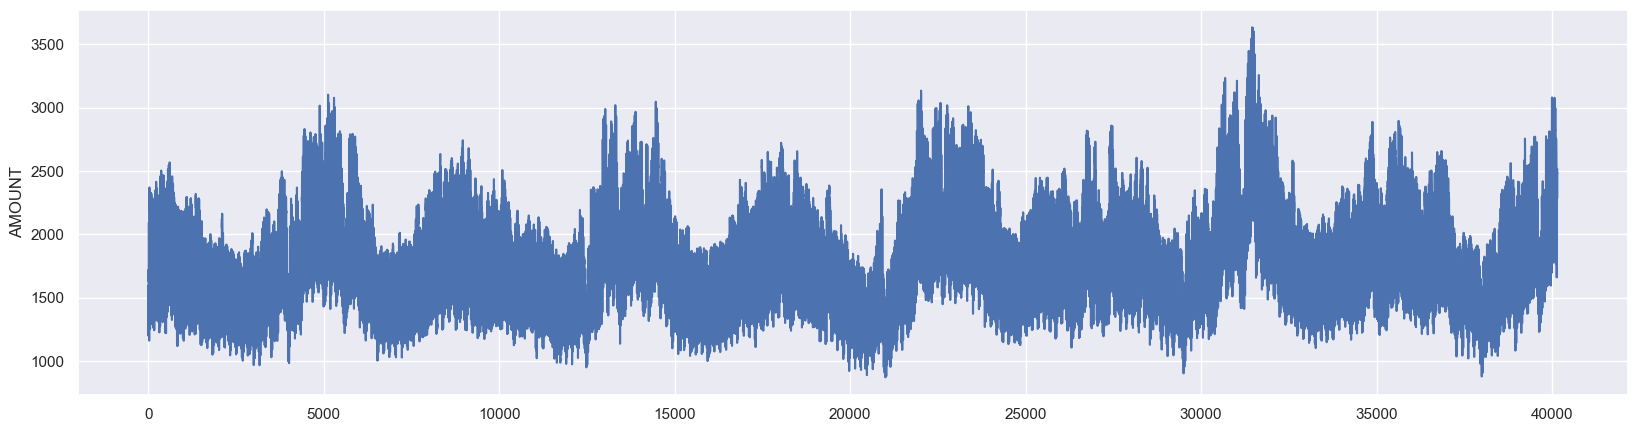

In [22]:
sns.set()

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = all_data_train, x=all_data_train.index, y="AMOUNT", ax=ax)

plt.show()

#### 2.1 Yıllık bazda özel aralıkların incelenmesi

In [23]:
def time_graph(DATA, SECONDARY_TIME, DECK):
    pass_df = pd.DataFrame(DATA.groupby(["YEAR",SECONDARY_TIME])["AMOUNT"].agg("mean")).reset_index()
    pass_df[f"YEAR_{SECONDARY_TIME}"] = pass_df["YEAR"].astype("str") +"-"+ pass_df[SECONDARY_TIME].astype("str")

    plt.figure(figsize=(20,5))
    plt.plot(pass_df[f"YEAR_{SECONDARY_TIME}"], pass_df["AMOUNT"])
    plt.title(f"{SECONDARY_TIME}")

    plt.xticks(np.arange(0, pass_df.shape[0], DECK),rotation=90, ha='right')

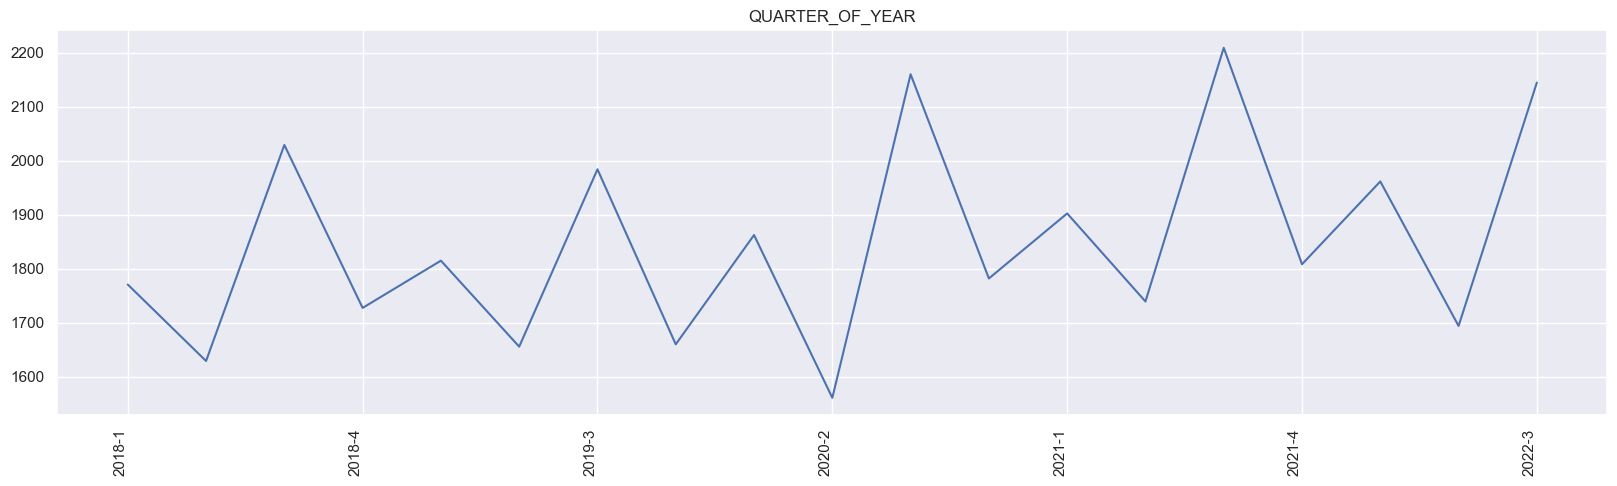

In [24]:
time_graph(all_data_train, "QUARTER_OF_YEAR", 3)

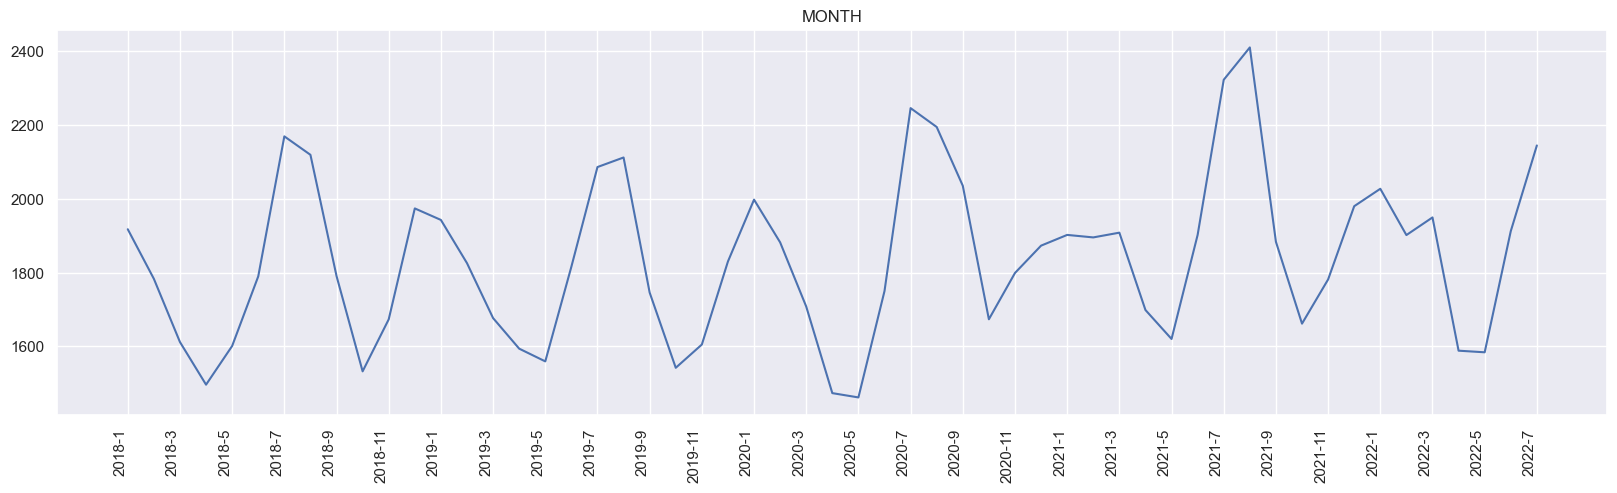

In [25]:
time_graph(all_data_train, "MONTH", 2)

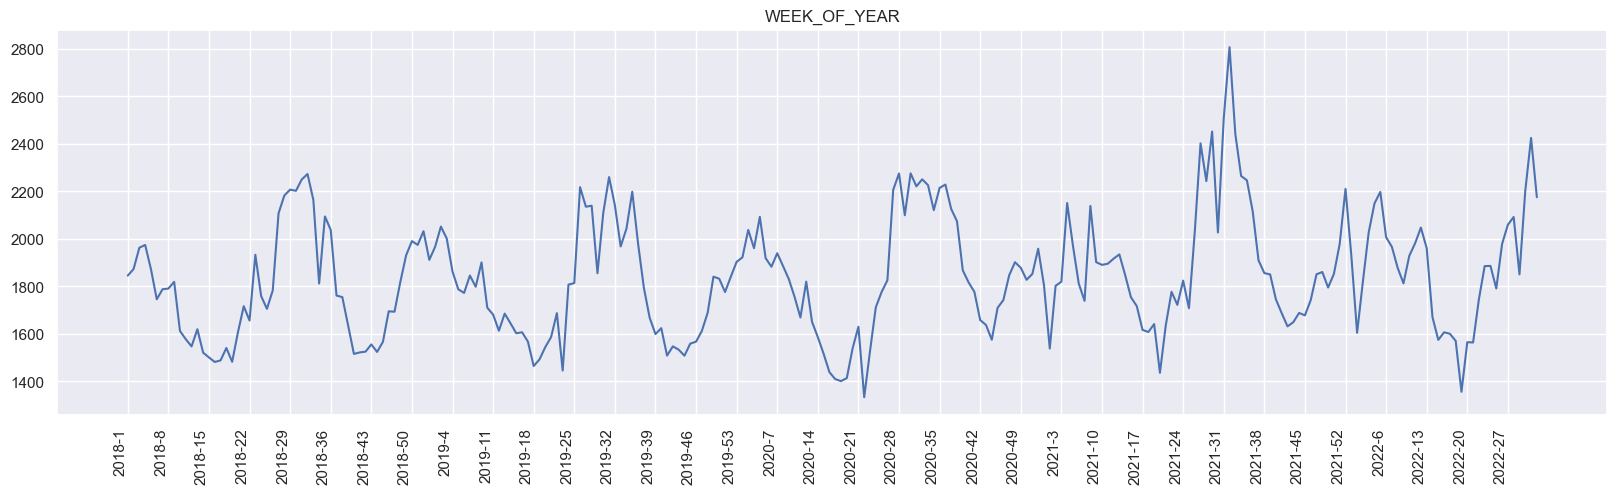

In [26]:
time_graph(all_data_train, "WEEK_OF_YEAR", 7)

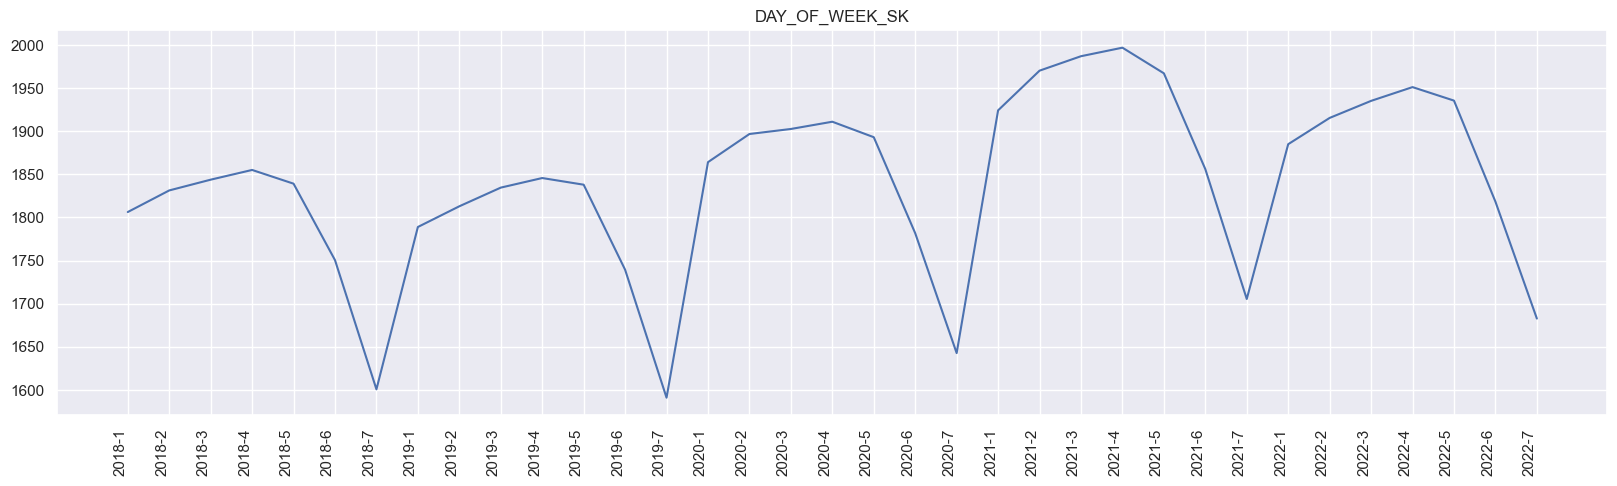

In [27]:
time_graph(all_data_train, "DAY_OF_WEEK_SK", 1)

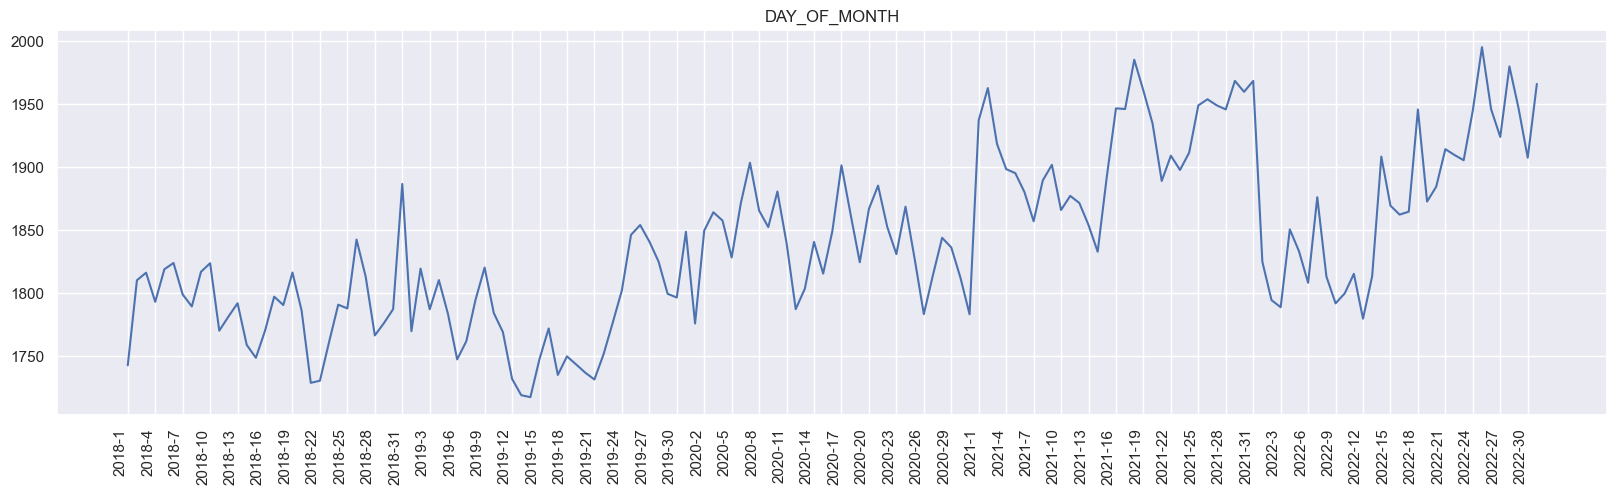

In [28]:
time_graph(all_data_train, "DAY_OF_MONTH", 3)

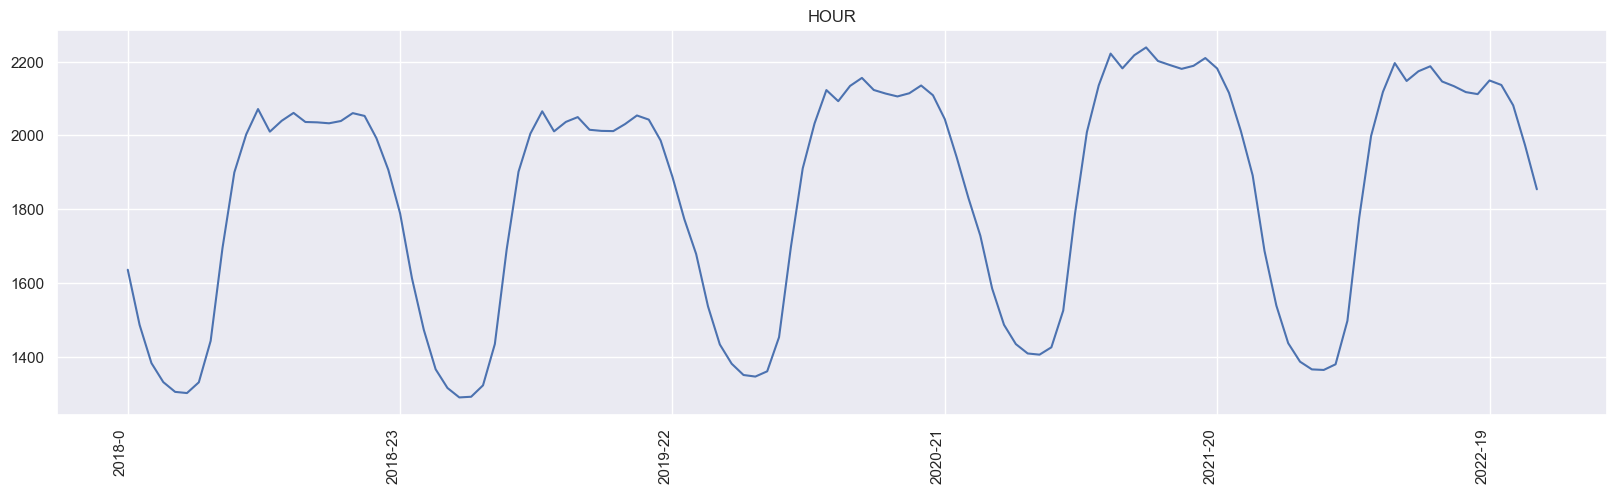

In [29]:
time_graph(all_data_train, "HOUR", 23)

## 2.2-Değişken Türetme

#### 2.2.1. Gece - Gündüz Flag

In [30]:
import pandas as pd
import ephem
import pytz

# Define a function to calculate the sunrise and sunset times for a given location and date
def calculate_sunrise_sunset(row):
    # Set the location coordinates
    location = ephem.Observer()
    location.lat = '38.4237'  # Latitude of Izmir
    location.lon = '27.1428'  # Longitude of Izmir
    
    # Set the date attribute of the location object
    location.date = row['CALENDAR_DATE']
    
    # Calculate the sunrise and sunset times for the specified date
    sunrise_time = location.next_rising(ephem.Sun()).datetime()
    sunset_time = location.next_setting(ephem.Sun()).datetime()
    
    # Convert to local timezone
    local_timezone = pytz.timezone('Europe/Istanbul')
    sunrise_time = sunrise_time.replace(tzinfo=pytz.utc).astimezone(local_timezone)
    sunset_time = sunset_time.replace(tzinfo=pytz.utc).astimezone(local_timezone)
    
    # Return the sunrise and sunset times as a tuple
    return (sunrise_time, sunset_time)

# Create a sample DataFrame with a date column
data = {
    'CALENDAR_DATE': pd.date_range('2018-01-01', '2022-08-31')
}
df = pd.DataFrame(data)

# Apply the calculate_sunrise_sunset function to the date column
df[['sunrise', 'sunset']] = df.apply(calculate_sunrise_sunset, axis=1, result_type='expand')

df['SUNRISE_HOUR'] = df.sunrise.dt.hour
df['SUNSET_HOUR'] = df.sunset.dt.hour
df['SUNSHINE_MINUTE'] =  (df.sunset.dt.hour * 60 + df.sunset.dt.minute) - (df.sunrise.dt.hour * 60 + df.sunrise.dt.minute)

df.drop(columns=["sunrise","sunset"], inplace=True)
df.CALENDAR_DATE = df.CALENDAR_DATE.astype("str")

df.tail()

,CALENDAR_DATE,SUNRISE_HOUR,SUNSET_HOUR,SUNSHINE_MINUTE
1699,2022-08-27,6,19,794
1700,2022-08-28,6,19,791
1701,2022-08-29,6,19,789
1702,2022-08-30,6,19,786
1703,2022-08-31,6,19,784


In [31]:
all_data_train["CALENDAR_DATE"] = all_data[:40152].TARIH_COL.astype(str).str.slice(stop=10).values
all_data_sample["CALENDAR_DATE"] = all_data[40152:].TARIH_COL.astype(str).str.slice(stop=10).values

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
all_data_train = all_data_train.merge(df, how="left", on="CALENDAR_DATE")
all_data_sample = all_data_sample.merge(df, how="left", on="CALENDAR_DATE")

In [33]:
gece_gunduz_train = []

gece_gunduz_train = ((all_data_train['HOUR'] > all_data_train['SUNRISE_HOUR']) &
               (all_data_train['HOUR'] < all_data_train['SUNSET_HOUR'])).astype(int).tolist()

gece_gunduz_sample = []

gece_gunduz_sample = ((all_data_sample['HOUR'] > all_data_sample['SUNRISE_HOUR']) &
               (all_data_sample['HOUR'] < all_data_sample['SUNSET_HOUR'])).astype(int).tolist()

all_data_train["GUNDUZ_MU"] = gece_gunduz_train
all_data_sample["GUNDUZ_MU"] = gece_gunduz_sample


#### 2.2.4.İzmir - Manisa Ağırlıklandırma

In [34]:
all_data

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,TESIS_SAYISI,KISI_SAYISI,TARIH_COL,AMOUNT,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu
0,1,1,1,1,0,1,0,100,200,1,0,0.4482,0.452,0.2309,0.230900,0.130400,0.133600,0,1,2018,207,24330,2018-01-01 00:00:00,1593.944216,5.2,1.9,79.0,30.0,16.6,1020.0,2.0,0.8,92.0,360.0,0.0,1020.6,4320519.0,0.95,360.0,1429643.0,1.17,108.0
1,1,1,1,1,0,1,0,100,200,1,0,0.4482,0.452,0.2309,0.230900,0.130400,0.133600,1,1,2018,207,24330,2018-01-01 01:00:00,1513.933887,7.0,1.1,66.0,40.0,16.6,1019.0,2.0,1.0,93.0,NaN,0.0,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0
2,1,1,1,1,0,1,0,100,200,1,0,0.4482,0.452,0.2309,0.230900,0.130400,0.133600,2,1,2018,207,24330,2018-01-01 02:00:00,1402.612637,4.0,1.0,81.0,360.0,11.2,1019.0,1.0,0.0,93.0,NaN,0.0,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0
3,1,1,1,1,0,1,0,100,200,1,0,0.4482,0.452,0.2309,0.230900,0.130400,0.133600,3,1,2018,207,24330,2018-01-01 03:00:00,1278.527266,3.5,0.9,83.0,10.0,13.0,1020.0,0.6,-0.4,93.0,360.0,0.0,1019.9,4320519.0,0.95,360.0,1429643.0,1.17,108.0
4,1,1,1,1,0,1,0,100,200,1,0,0.4482,0.452,0.2309,0.230900,0.130400,0.133600,4,1,2018,207,24330,2018-01-01 04:00:00,1220.697701,2.0,1.0,93.0,250.0,3.6,1019.0,0.0,-1.0,93.0,320.0,5.4,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40891,31,3,3,3,0,36,0,100,200,0,0,2.1700,3.420,1.5972,2.437383,0.335187,0.342716,19,8,2022,266,251303,2022-08-31 19:00:00,0.000000,27.0,20.1,66.0,330.0,18.4,1009.0,25.0,20.0,74.0,320.0,11.2,1010.0,4462056.0,0.82,372.0,1468279.0,0.80,111.0
40892,31,3,3,3,0,36,0,100,200,0,0,2.1700,3.420,1.5972,2.437383,0.335187,0.342716,20,8,2022,266,251303,2022-08-31 20:00:00,0.000000,25.0,20.0,74.0,10.0,11.2,1009.0,24.0,19.9,78.0,330.0,13.0,1009.0,4462056.0,0.82,372.0,1468279.0,0.80,111.0
40893,31,3,3,3,0,36,0,100,200,0,0,2.1700,3.420,1.5972,2.437383,0.335187,0.342716,21,8,2022,266,251303,2022-08-31 21:00:00,0.000000,24.6,20.5,78.0,10.0,5.4,1009.5,24.1,19.8,77.0,0.0,0.0,1009.8,4462056.0,0.82,372.0,1468279.0,0.80,111.0
40894,31,3,3,3,0,36,0,100,200,0,0,2.1700,3.420,1.5972,2.437383,0.335187,0.342716,22,8,2022,266,251303,2022-08-31 22:00:00,0.000000,23.0,21.1,89.0,130.0,7.6,1009.0,23.0,20.0,83.0,360.0,3.6,1009.0,4462056.0,0.82,372.0,1468279.0,0.80,111.0


In [35]:
all_data_train["SICAKLIK"] = (all_data_train["temp_IZMIR"]*0.85) + (all_data_train["temp_MANISA"]*0.15)
all_data_train["DWPT"] = (all_data_train["dwpt_IZMIR"]*0.85) + (all_data_train["dwpt_MANISA"]*0.15)
all_data_train["WDIR"] = (all_data_train["wdir_IZMIR"]*0.85) + (all_data_train["wdir_MANISA"]*0.15)
all_data_train["WSPD"] = (all_data_train["wspd_IZMIR"]*0.85) + (all_data_train["wspd_MANISA"]*0.15)
all_data_train["PRES"] = (all_data_train["pres_IZMIR"]*0.85) + (all_data_train["pres_MANISA"]*0.15)
all_data_train["NUFUS_ARTIS_HIZI"] = (all_data_train["İzmir Nüfus Artış Hızı"]*0.85) + (all_data_train["Manisa Nüfus Artış Hızı"]*0.15)
all_data_train["NUFUS_YOGUNLUGU"] = (all_data_train["İzmir Nüfus Yoğunluğu"]*0.85) + (all_data_train["Manisa Nüfus Yoğunluğu"]*0.15)
all_data_train["NUFUS"] = ((all_data_train["İzmir Nüfusu"]*0.85) + (all_data_train["Manisa Nüfusu"]*0.15)) + all_data_train["KISI_SAYISI"]

In [36]:
all_data_sample["SICAKLIK"] = (all_data_sample["temp_IZMIR"]*0.85) + (all_data_sample["temp_MANISA"]*0.15)
all_data_sample["DWPT"] = (all_data_sample["dwpt_IZMIR"]*0.85) + (all_data_sample["dwpt_MANISA"]*0.15)
all_data_sample["WDIR"] = (all_data_sample["wdir_IZMIR"]*0.85) + (all_data_sample["wdir_MANISA"]*0.15)
all_data_sample["WSPD"] = (all_data_sample["wspd_IZMIR"]*0.85) + (all_data_sample["wspd_MANISA"]*0.15)
all_data_sample["PRES"] = (all_data_sample["pres_IZMIR"]*0.85) + (all_data_sample["pres_MANISA"]*0.15)
all_data_sample["NUFUS_ARTIS_HIZI"] = (all_data_sample["İzmir Nüfus Artış Hızı"]*0.85) + (all_data_sample["Manisa Nüfus Artış Hızı"]*0.15)
all_data_sample["NUFUS_YOGUNLUGU"] = (all_data_sample["İzmir Nüfus Yoğunluğu"]*0.85) + (all_data_sample["Manisa Nüfus Yoğunluğu"]*0.15)
all_data_sample["NUFUS"] = ((all_data_sample["İzmir Nüfusu"]*0.85) + (all_data_sample["Manisa Nüfusu"]*0.15)) + all_data_sample["KISI_SAYISI"]

#### 2.2.4.Tatil flagler düzenleme

In [37]:
all_data_train['RELIGIOUS_DAY_FLAG_SK'].replace([150, 151, 152, 160, 161, 162, 163], 1, inplace=True)
all_data_train['RELIGIOUS_DAY_FLAG_SK'].replace(100, 1, inplace=True)

all_data_train['NATIONAL_DAY_FLAG_SK'].replace([201, 202, 203, 204], 1, inplace=True)
all_data_train['NATIONAL_DAY_FLAG_SK'].replace(200, 0, inplace=True)

In [38]:
all_data_sample['RELIGIOUS_DAY_FLAG_SK'].replace([150, 151, 152, 160, 161, 162, 163], 1, inplace=True)
all_data_sample['RELIGIOUS_DAY_FLAG_SK'].replace(100, 1, inplace=True)

all_data_sample['NATIONAL_DAY_FLAG_SK'].replace([201, 202, 203, 204], 1, inplace=True)
all_data_sample['NATIONAL_DAY_FLAG_SK'].replace(200, 0, inplace=True)

#### 2.2.5.Elektrik Fiyatlar Düzenleme

In [39]:
ALL_HOLIDAY_FLAG_train = ((all_data_train['WEEKEND_FLAG'] == 1) |
                    (all_data_train['RAMADAN_FLAG'] == 1) |
                    (all_data_train['RELIGIOUS_DAY_FLAG_SK'] == 1) | 
                    (all_data_train['NATIONAL_DAY_FLAG_SK'] == 1) | 
                    (all_data_train['PUBLIC_HOLIDAY_FLAG'] == 1) ).astype(int).tolist() 

ALL_HOLIDAY_FLAG_test = ((all_data_sample['WEEKEND_FLAG'] == 1) |
                    (all_data_sample['RAMADAN_FLAG'] == 1) |
                    (all_data_sample['RELIGIOUS_DAY_FLAG_SK'] == 1) | 
                    (all_data_sample['NATIONAL_DAY_FLAG_SK'] == 1) | 
                    (all_data_sample['PUBLIC_HOLIDAY_FLAG'] == 1) ).astype(int).tolist() 

all_data_train["ALL_HOLIDAY_FLAG"] = ALL_HOLIDAY_FLAG_train
all_data_sample["ALL_HOLIDAY_FLAG"] = ALL_HOLIDAY_FLAG_test

#### 2.2.6.Kategorik Değişkenler Düzenlemesi

In [40]:
all_data_train['SEASON_SK'] = pd.Categorical(all_data_train['SEASON_SK'])
all_data_train['WEEK_OF_YEAR'] = pd.Categorical(all_data_train['WEEK_OF_YEAR'])
all_data_train['IS_MED'] = pd.Categorical(all_data_train['IS_MED'])
all_data_train['HOUR'] = pd.Categorical(all_data_train['HOUR'])
all_data_train['MONTH'] = pd.Categorical(all_data_train['MONTH'])
all_data_train['YEAR'] = pd.Categorical(all_data_train['YEAR'])
all_data_train['GUNDUZ_MU'] = pd.Categorical(all_data_train['GUNDUZ_MU'])
all_data_train['ALL_HOLIDAY_FLAG'] = pd.Categorical(all_data_train['ALL_HOLIDAY_FLAG'])

In [41]:
all_data_sample['SEASON_SK'] = pd.Categorical(all_data_sample['SEASON_SK'])
all_data_sample['WEEK_OF_YEAR'] = pd.Categorical(all_data_sample['WEEK_OF_YEAR'])
all_data_sample['IS_MED'] = pd.Categorical(all_data_sample['IS_MED'])
all_data_sample['HOUR'] = pd.Categorical(all_data_sample['HOUR'])
all_data_sample['MONTH'] = pd.Categorical(all_data_sample['MONTH'])
all_data_sample['YEAR'] = pd.Categorical(all_data_sample['YEAR'])
all_data_sample['GUNDUZ_MU'] = pd.Categorical(all_data_sample['GUNDUZ_MU'])
all_data_sample['ALL_HOLIDAY_FLAG'] = pd.Categorical(all_data_sample['ALL_HOLIDAY_FLAG'])

In [42]:
all_data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   DAY_OF_MONTH                           744 non-null    int32         
 1   DAY_OF_WEEK_SK                         744 non-null    int32         
 2   SEASON_SK                              744 non-null    category      
 3   QUARTER_OF_YEAR                        744 non-null    int32         
 4   WEEKEND_FLAG                           744 non-null    int32         
 5   WEEK_OF_YEAR                           744 non-null    category      
 6   RAMADAN_FLAG                           744 non-null    int32         
 7   RELIGIOUS_DAY_FLAG_SK                  744 non-null    int32         
 8   NATIONAL_DAY_FLAG_SK                   744 non-null    int32         
 9   PUBLIC_HOLIDAY_FLAG                    744 non-null    int32     

#### 2.2.6.Kullanılan Alanların Silinmesi

In [43]:
all_data_train_2 = all_data_train.drop(columns= ['temp_IZMIR', 'dwpt_IZMIR', 'rhum_IZMIR', 'wdir_IZMIR', 'wspd_IZMIR',
       'pres_IZMIR', 'temp_MANISA', 'dwpt_MANISA', 'rhum_MANISA',
       'wdir_MANISA', 'wspd_MANISA', 'pres_MANISA', 'İzmir Nüfusu',
       'İzmir Nüfus Artış Hızı', 'İzmir Nüfus Yoğunluğu', 'Manisa Nüfusu',
       'Manisa Nüfus Artış Hızı', 'Manisa Nüfus Yoğunluğu',
       "SUNRISE_HOUR", "SUNSET_HOUR",'CALENDAR_DATE', "WEEKEND_FLAG",
       "RAMADAN_FLAG","RELIGIOUS_DAY_FLAG_SK","NATIONAL_DAY_FLAG_SK","PUBLIC_HOLIDAY_FLAG", 
       "NUFUS_ARTIS_HIZI","NUFUS_YOGUNLUGU",'TL_kWH_MESKEN_ABONE_GRUBU',
 'TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU',
 'TL_kWH_TICARETHANE',
 'TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU',
 'TL_kWH_TICARETHANE_ABONE_GRUBU',
 'QUARTER_OF_YEAR',
 'TESIS_SAYISI',
"KISI_SAYISI",'DAY_OF_MONTH', 'DAY_OF_WEEK_SK','WEEK_OF_YEAR'])

In [44]:
all_data_sample_2 = all_data_sample.drop(columns= ['temp_IZMIR', 'dwpt_IZMIR', 'rhum_IZMIR', 'wdir_IZMIR', 'wspd_IZMIR',
       'pres_IZMIR', 'temp_MANISA', 'dwpt_MANISA', 'rhum_MANISA',
       'wdir_MANISA', 'wspd_MANISA', 'pres_MANISA', 'İzmir Nüfusu',
       'İzmir Nüfus Artış Hızı', 'İzmir Nüfus Yoğunluğu', 'Manisa Nüfusu',
       'Manisa Nüfus Artış Hızı', 'Manisa Nüfus Yoğunluğu',
       "SUNRISE_HOUR", "SUNSET_HOUR",'CALENDAR_DATE', "WEEKEND_FLAG",
       "RAMADAN_FLAG","RELIGIOUS_DAY_FLAG_SK","NATIONAL_DAY_FLAG_SK","PUBLIC_HOLIDAY_FLAG", 
       "NUFUS_ARTIS_HIZI","NUFUS_YOGUNLUGU",'TL_kWH_MESKEN_ABONE_GRUBU',
 'TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU',
 'TL_kWH_TICARETHANE',
 'TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU',
 'TL_kWH_TICARETHANE_ABONE_GRUBU',
 'QUARTER_OF_YEAR',
 'TESIS_SAYISI',
"KISI_SAYISI",'DAY_OF_MONTH', 'DAY_OF_WEEK_SK','WEEK_OF_YEAR'])

## 2.3.Numerik Analiz

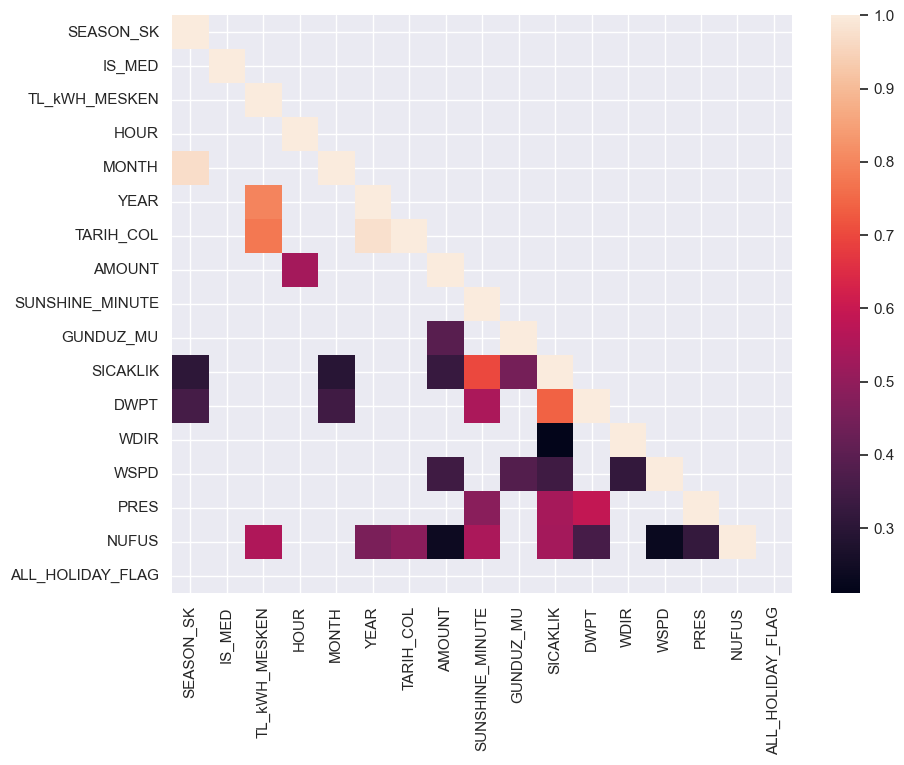

In [45]:
# Showing the correlations
correlations = all_data_train_2.corr().abs()
correlations = correlations[correlations > 0.2]


df_lt = correlations.where(np.tril(np.ones(correlations.shape)).astype(np.bool_))

sns.set(rc={'figure.figsize': (10, 7.5)})
sns.heatmap(df_lt)
plt.show(block=True)

In [46]:
all_data_train_3 = all_data_train_2.set_index("TARIH_COL")
all_data_train_3.shape

(40152, 16)

In [47]:
all_data_sample_3 = all_data_sample_2.set_index("TARIH_COL")
all_data_sample_3.shape

(744, 16)

# 3-Test_Train Split

In [54]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import sklearn.preprocessing
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from keras.layers import Dense,Dropout,SimpleRNN,LSTM, Flatten
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import  Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from lightgbm import LGBMRegressor



In [50]:
# Split the dataset into training and testing sets
all_data_train_3_dum = pd.get_dummies(all_data_train_3)

X = all_data_train_3_dum.drop(columns='AMOUNT', axis=1)  

# drop the target column from the features
y = all_data_train_3_dum['AMOUNT']  

# transform data
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# set the target column as the labels
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42, shuffle=False)

# Print the shapes of the train and test sets
print('Training set shape:', X_train.shape, y_train.shape)
print('Testing set shape:', X_test.shape, y_test.shape)

Training set shape: (32121, 58) (32121,)
Testing set shape: (8031, 58) (8031,)


# 3-Model  LightGBMRegressor

In [ ]:


# Define the model
lgbm = LGBMRegressor()

# Define the grid of hyperparameters to search over
param_grid = {
    'learning_rate': [0.05, 0.01,0.001],
    'max_depth':[3, 5, 7,10],
    'n_estimators': [100,150,200],
    'num_leaves':[40,80,90],
    'colsample_bytree': [ 0.7, 0.8, 0.9],
    'subsample': [ 0.7, 0.8,0.9],
    'min_child_samples': [20,30,40]
}

# Define the TimeSeriesSplit object One of the most commonly used time-series cross-validation methods is the "rolling window" approach. In this approach, you start with a training set that contains the first n observations, and then move the window by k observations to create the next training set. You continue this process until you reach the end of the data. For each training set, you train your model and evaluate its performance on the corresponding test set.
tscv = TimeSeriesSplit(n_splits=5)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=lgbm, 
                           param_grid=param_grid, 
                           cv=tscv,
                           n_jobs=-2,
                           scoring='neg_mean_absolute_percentage_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-2,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.05, 0.01, 0.001],
                         'max_depth': [3, 5, 7, 10],
                         'min_child_samples': [20, 30, 40],
                         'n_estimators': [100, 150, 200],
                         'num_leaves': [40, 80, 90],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_absolute_percentage_error')

In [51]:
# Get the best parameters and the best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
best_params ={'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_samples': 30,
 'n_estimators': 200,
 'num_leaves': 80,
 'subsample': 0.7}

In [52]:
best_score

NameError: name 'best_score' is not defined

In [55]:
# transform data
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Create a new model with the best hyperparameters
lgbm_best = LGBMRegressor(**best_params)

# Fit the new model to the data
lgbm_best.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=10,
              min_child_samples=30, n_estimators=200, num_leaves=80,
              subsample=0.7)

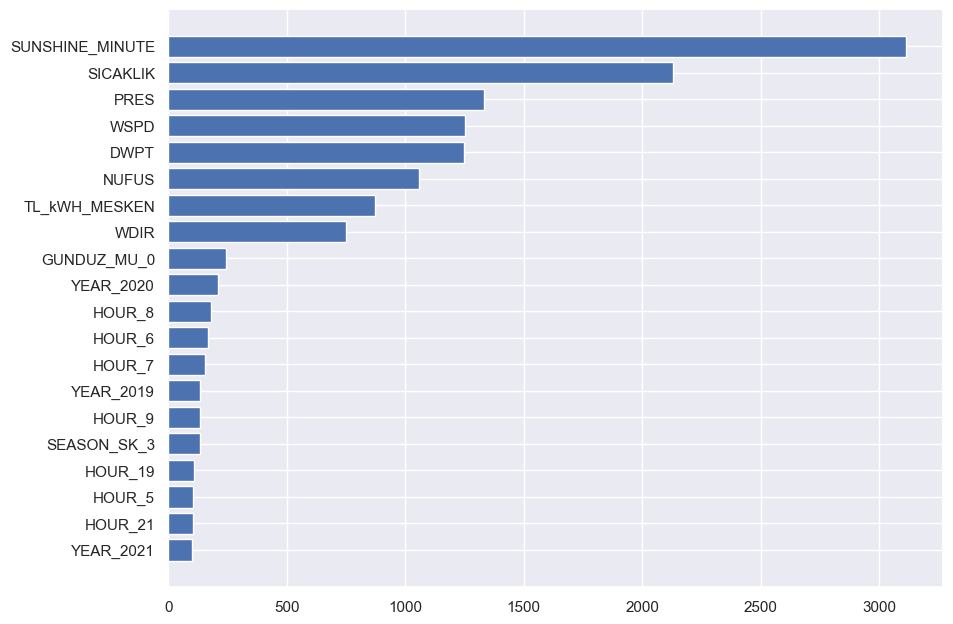

In [56]:
# Step 5: Plot feature importances
features = pd.DataFrame(X_train, columns=all_data_train_3_dum.drop(columns="AMOUNT").columns).columns
importance_values = lgbm_best.feature_importances_


# Sort data and labels in descending order
sorted_data, sorted_labels = zip(*sorted(zip(importance_values, features), reverse=True))

plt.barh(y=range(len(features[:20])),
   width=sorted_data[:20],
   tick_label=sorted_labels[:20])
# Invert y-axis to plot bars in descending order
plt.gca().invert_yaxis()

# Show plot
plt.show()
plt.show()

## 3.1.Model Sonuç Zaman Grafiği

In [57]:
all_data_sample_3_dum = pd.get_dummies(all_data_sample_3)
all_data_sample_3_dum.shape

(744, 40)

In [58]:
all_data_sample_3_dum['SEASON_SK_1'] = False
all_data_sample_3_dum['SEASON_SK_2'] = False
all_data_sample_3_dum['SEASON_SK_4'] = False
all_data_sample_3_dum['IS_MED_1'] = False
all_data_sample_3_dum['HOUR_0'] = False
all_data_sample_3_dum['MONTH_1'] = False
all_data_sample_3_dum['MONTH_2'] = False
all_data_sample_3_dum['MONTH_3'] = False
all_data_sample_3_dum['MONTH_4'] = False
all_data_sample_3_dum['MONTH_5'] = False
all_data_sample_3_dum['MONTH_5'] = False
all_data_sample_3_dum['MONTH_6'] = False
all_data_sample_3_dum['MONTH_7'] = False
all_data_sample_3_dum['MONTH_9'] = False
all_data_sample_3_dum['MONTH_10'] = False
all_data_sample_3_dum['MONTH_11'] = False
all_data_sample_3_dum['MONTH_12'] = False
all_data_sample_3_dum['YEAR_2018'] = False
all_data_sample_3_dum['YEAR_2019'] = False
all_data_sample_3_dum['YEAR_2020'] = False
all_data_sample_3_dum['YEAR_2021'] = False


In [59]:
# transform data
scaler = MinMaxScaler()
scaled_Sample = scaler.fit_transform(all_data_sample_3_dum.drop(columns="AMOUNT") )

# Make predictions on the new input sequences
predictions = lgbm_best.predict(scaled_Sample)

# Print the predicted values
pd.DataFrame(predictions).head(24)

,0
0,1866.599714
1,1856.639011
2,1889.188049
3,1879.866047
4,1845.030677
5,1734.866996
6,1704.825024
7,1720.656504
8,1665.664976
9,1726.189105


In [60]:
sample = pd.read_csv("sample_submission.csv")
sample["Tarih"] = pd.to_datetime(sample["Tarih"])

sample["Dağıtılan Enerji (MWh)"] = pd.DataFrame(predictions).values
sample = sample.set_index("Tarih")

In [61]:
deneme = sample.copy()

array([[<Axes: title={'center': 'Dağıtılan Enerji (MWh)'}>]], dtype=object)

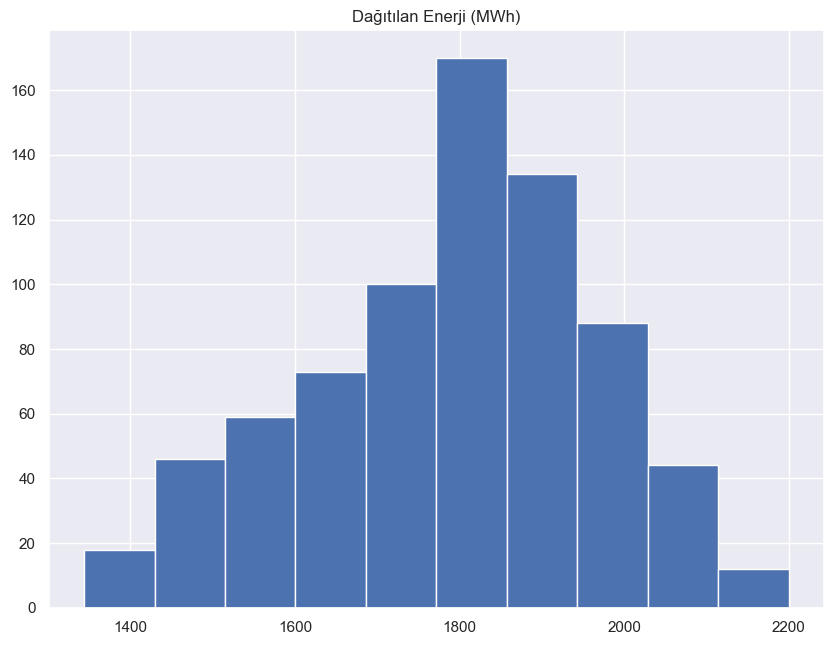

In [62]:
deneme.hist()

In [63]:
deneme = sample.copy()

In [66]:
result = pd.concat([reselt_1, reselt_2,reselt_3,reselt_4])
result.shape


(744, 2)

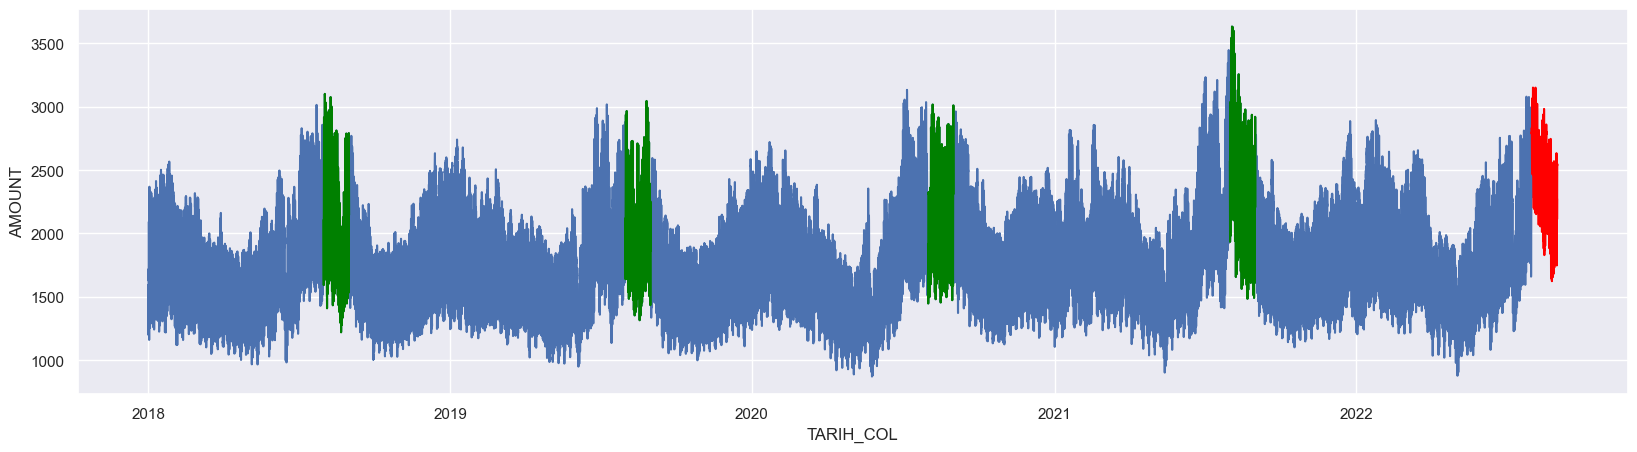

In [67]:
sns.set()

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = all_data_train_3, x=all_data_train_3.index, y="AMOUNT", ax=ax)
sns.lineplot(data = all_data_train_3['2018-08-01 00:00:00':'2018-08-31 23:00:00'], x=all_data_train_3['2018-08-01 00:00:00':'2018-08-31 23:00:00'].index, y="AMOUNT", ax=ax, color="green")
sns.lineplot(data = all_data_train_3['2019-08-01 00:00:00':'2019-08-31 23:00:00'], x=all_data_train_3['2019-08-01 00:00:00':'2019-08-31 23:00:00'].index, y="AMOUNT", ax=ax, color="green")
sns.lineplot(data = all_data_train_3['2020-08-01 00:00:00':'2020-08-31 23:00:00'], x=all_data_train_3['2020-08-01 00:00:00':'2020-08-31 23:00:00'].index, y="AMOUNT", ax=ax, color="green")
sns.lineplot(data = all_data_train_3['2021-08-01 00:00:00':'2021-08-31 23:00:00'], x=all_data_train_3['2021-08-01 00:00:00':'2021-08-31 23:00:00'].index, y="AMOUNT", ax=ax, color="green")
sns.lineplot(data = result, x=result.index, y="Dağıtılan Enerji (MWh)_1", ax=ax, color="red")

plt.show()

In [71]:
result['Dağıtılan Enerji (MWh)_1'].to_csv("GDZ_Datathon_202304_LGBM_V11.csv")

array([[<Axes: title={'center': 'Dağıtılan Enerji (MWh)'}>,
        <Axes: title={'center': 'Dağıtılan Enerji (MWh)_1'}>]],
      dtype=object)

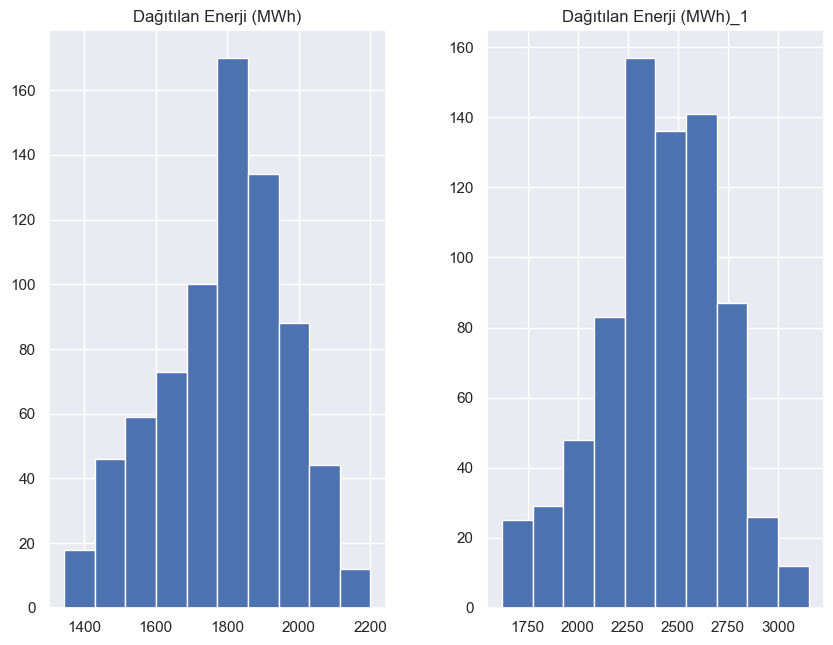

In [69]:
result.hist()

In [ ]:
from sklearn import preprocessing